Okay, so let's start importing some libraries. Of course 'pandas' will be necessary for having the data in dataframes format. The 'requests', 'zipfile' and 'io' will be used for navigating through the data that we will import, as we won't be using exactly an API. The third one will be used for identifying files with the .xml extension, after changing our work environment into that folder. The forth will be used precisely for changing that environment.
After, the fith will be used for navigating through the .xml file and extract the information we require. The seventh will be used for converting some formats into something we can process with pandas. And the last ones will be used just for plotting some graphs which will be useful for our analysis.

In [1]:
import pandas as pd
import requests, zipfile, io
import glob
import os
import xml.etree.ElementTree as et
from string import ascii_letters
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Now let's import the data that was provided. There were two files, a .csv and a .xlsx, but as .csv is quite more usual let's focus on the .xlsx. Both have the same content.

In [2]:
df = pd.read_excel('../data/measurements2.xlsx')

And let's start by checking the data.

In [3]:
df.head(2)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN


So now we have several columns. As our purpose is to determine which one will be the best fuel let's check what we can know from the data.
Preliminary we should consider that the consume is the most important property, as the company will want to save as much money as possible. However, as they are considering if using a fuel with less quantity of emissions will be worthy, we will want to quantify them. Now that's when it becomes tricky, as we need to find a way to discriminate if we consider the other categories worthy or not of taking part in our calculations (i.e. the temperature inside vs. outside will be useful?).
Let's check the quality of the data. We can presume that the distance will be directly related to the consume, right? But let's check if this is the situation:

In [4]:
df['distance'].unique()

array([ 28. ,  12. ,  11.2,  12.9,  18.5,   8.3,   7.8,  12.3,   4.9,
        11.9,  12.4,  11.8,  24.7,  17.3,  33.4,  25.9,  25.3,  14.2,
        17.9,  18.4,  18.3,  32.6,  19. ,  12.1,  20. ,   4.5,  11.7,
        10.2,   5.4,   2. ,  16. ,  27.3,  10.6,  11.6,  13.1,   6.1,
       153.5,   2.9,   2.1,   9.8,   6.8,  14. ,  13.9,   9.7,  24.8,
        34.8,   5.2,  10.5,  13.2,  13. ,  12.2,  12.5,  15.7,   6.4,
         5.3,  26.2,  18.8,  22.9, 162.7,  16.6,  15.9,   5.1,  22.4,
        31.1,  16.1,   4.2,  17.4,  23.5,   7. ,  20.1,  20.8,   1.7,
        35.9,  36.9,  16.8,   9.9,  36.6,  44.9,  21.6,  39.4,  26.6,
        53.2,  18.9,  43.5,  16.4,  21.1,  22.7,  44.4,  35.8,  40.6,
        14.1,  58.7,  16.2,  31.8,  51.6,  38.6,  81.2, 130.3,  67.2,
        43.7,  56.1,  39. ,  38.5,  28.2,  19.6,  22.2,  13.6,  12.6,
         8.7,   7.9,   2.4,  18.1,   1.3,  13.4,  12.8,  29. ,  31.4,
        27.1,  25.2,  14.3,  16.9,   9.2,  31.5,  24.9,  17. ,   7.4,
        25.7,  24.5,

In [5]:
df.loc[df["distance"] == 1.3]

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
210,1.3,11.5,21,20.0,10,NaN,SP98,0,0,0,NaN,NaN


Okay now this doesn't make sense at all. How is it possible that the consume is that high in a trip of only 1.3 km? You can try by yourshelf, but at first sight it seems that there are some trips that weren't recorded propertly. Afterall we are suppossing that all the cars in the fleet are high displacement cars. But for now let's consider that everything is allright.

In [6]:
df['gas_type'].unique()

array(['E10', 'SP98'], dtype=object)

Why is this useful? Because we first need to check that we can identify each trip by only one type of fuel.

In [7]:
df['gas_type'].isnull().sum()

0

In [8]:
df['specials'] = df['specials'].fillna('None')
df['refill liters'] = df['refill liters'].fillna(0)
df['refill gas'] = df['refill gas'].fillna('None')

Why the last commands? Because I personally prefer having the 'Nan' identified by something else ;)

In [9]:
df.isnull().sum()

distance          0
consume           0
speed             0
temp_inside      12
temp_outside      0
specials          0
gas_type          0
AC                0
rain              0
sun               0
refill liters     0
refill gas        0
dtype: int64

So, we have some 'Nan' in the 'temp_inside' category. As they are only 12 entries, I believe it could be useful just to substitute them by the median or the mode. Let's see which category is more suitable.

No handles with labels found to put in legend.


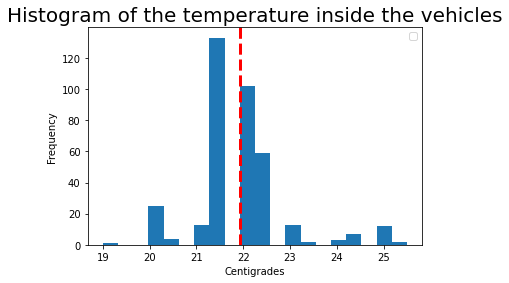

In [10]:
plt.hist(df.temp_inside, bins=20)
plt.axvline(np.mean(df.temp_inside),
            c="red",
            linewidth= 3.,
            linestyle='--')
plt.title('Histogram of the temperature inside the vehicles', size=20)
plt.xlabel('Centigrades')
plt.ylabel('Frequency')
plt.legend()
plt.show();

In [11]:
df['temp_inside'].median()

22.0

In [12]:
df['temp_inside'].mode()

0    21.5
dtype: float64

So viewing the histogram, let's say that the median will be useful enough for our purposes. Why? Because the mode is of course more representative, but the median shows better the real distribution of the graph. Just try adding all the frequencies and you will see it clearly.

In [13]:
df['temp_inside'] = df['temp_inside'].fillna(22)

Let's check now some of the other columns. The first thing I like is to modify the names so I have no problems later if I have to use brackets or not.

In [14]:
df.rename(columns={'refill gas':'refill_gas','refill liters':'refill_liters'}, inplace=True)

And now let's check the 'specials' category, as it will show what type of information is it showing.

In [15]:
df.sample(1)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
247,12.3,5.0,42,22.5,10,None,E10,0,0,0,0.0,None


In [16]:
df['specials'].unique()

array(['None', 'AC rain', 'AC', 'rain', 'snow', 'AC snow',
       'half rain half sun', 'sun', 'AC sun', 'sun ac', 'ac', 'AC Sun',
       'ac rain'], dtype=object)

In [17]:
df[df['AC']==1].head(2)

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
40,12.4,4.0,55,21.5,7,AC rain,E10,1,1,0,0.0,None
41,4.5,5.0,29,21.5,7,AC,E10,1,0,0,0.0,None


Okay, we can see that the 'specials' category is showing if there was a special incidence under the categories of 'AC', 'rain' or 'sun'. If there had been any specific event, it should appear remarkable at the pool. For example, if the row is showing 'half rain half sun', we would like to expect a 1 at rain and a 1 at sun, right? Of course we could pretend a 0.5 in each category, but it would make the ulterior analysis more difficult. Let's pretend that a 1:1 will make the deal.

In [18]:
df.loc[df["specials"] == "snow", "AC"] = 0
df.loc[df["specials"] == "snow", "rain"] = 1
df.loc[df["specials"] == "snow", "sun"] = 0

df.loc[df["specials"] == "AC snow", "AC"] = 1
df.loc[df["specials"] == "AC snow", "rain"] = 1
df.loc[df["specials"] == "AC snow", "sun"] = 0

df.loc[df["specials"] == "rain", "AC"] = 0
df.loc[df["specials"] == "rain", "rain"] = 1
df.loc[df["specials"] == "rain", "sun"] = 0

df.loc[df["specials"] == "half rain half sun", "AC"] = 0
df.loc[df["specials"] == "half rain half sun", "rain"] = 1
df.loc[df["specials"] == "half rain half sun", "sun"] = 1

df.loc[df["specials"] == "ac", "AC"] = 1
df.loc[df["specials"] == "ac", "rain"] = 0
df.loc[df["specials"] == "ac", "sun"] = 0

df.loc[df["specials"] == "AC", "AC"] = 1
df.loc[df["specials"] == "AC", "rain"] = 0
df.loc[df["specials"] == "AC", "sun"] = 0

df.loc[df["specials"] == "AC rain", "AC"] = 1
df.loc[df["specials"] == "AC rain", "rain"] = 1
df.loc[df["specials"] == "AC rain", "sun"] = 0

df.loc[df["specials"] == "sun", "AC"] = 0
df.loc[df["specials"] == "sun", "rain"] = 0
df.loc[df["specials"] == "sun", "sun"] = 1

df.loc[df["specials"] == "AC sun", "AC"] = 1
df.loc[df["specials"] == "AC sun", "rain"] = 0
df.loc[df["specials"] == "AC sun", "sun"] = 1

df.loc[df["specials"] == "sun ac", "AC"] = 1
df.loc[df["specials"] == "sun ac", "rain"] = 0
df.loc[df["specials"] == "sun ac", "sun"] = 1

df.loc[df["specials"] == "AC Sun", "AC"] = 1
df.loc[df["specials"] == "AC Sun", "rain"] = 0
df.loc[df["specials"] == "AC Sun", "sun"] = 1

df.loc[df["specials"] == "ac rain", "AC"] = 1
df.loc[df["specials"] == "ac rain", "rain"] = 1
df.loc[df["specials"] == "ac rain", "sun"] = 0

What have we done? Just assigned the corresponding values to each category. It would be more intelligent to create a function for each environment if the database size was bigger, but for this case doing these operations like that should be enough.

In [19]:
df.drop(['specials'], axis=1, inplace=True)

So now we don't need the 'specials' category anymore, as we have transcribed all the info to the other categories. Let's see how we can enrich our database.

In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Would be nice to have an estimation of the fuel prices as well as the emissions, so later we may get a prediction of the cost based on the driving conditions.

Let's use the public data offered by the frech goverment. Why? Because France was one of the first countries in Europe that changed it's service of SP95 fuel into the SP95-E10. Of course you can addapt your prediction to other markets, like the north american. Let's imagine for now that the company was origined in France, and therefore they are considering if it makes sense to continue with their usual fuel of it's worthy to change to a more 'ecologist' one.

In [20]:
r = requests.get('https://donnees.roulez-eco.fr/opendata/jour')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../data/")

Here we have downloaded information about the daily prices of both fuels offered by all the gas stations in France. You can also addapt your prediction to monthly consumptions, but the database will be quite bigger.
So first we need to change our working directory into the one where we have downloaded the .xml file.

Remember to delete any older .xml files from the folder first, as it may interfer with the loading.

In [24]:
os.chdir("../data")

Now let's identify the file.

In [25]:
xml_file = glob.glob("*.xml")

And now let's try to parse its content into something that we can use to extract the information we need.

In [26]:
xtree = et.parse(xml_file[0])
xroot = xtree.getroot()

So, now we will iterate over all the tags under the category 'prix', which content the information we seek (name of the fuel and it value). For fully understanding this point if you experience any problem, you can access the corresponding resource under its reference (at the README), or at least trying to open the .xml file and explore it by yourshelf.

In [27]:
name = []
for node in xroot.iter('prix'): 
    name.append(node.attrib.get("nom"))

In [28]:
price = []
for node in xroot.iter('prix'): 
    price.append(node.attrib.get("valeur"))

Until here, we have iterate over the tags that were of our interest and we have save them into a list, so later we can combine them into a dictionary.

In [29]:
df1_dict = {"name":name, "price":price}

In [30]:
df1 = pd.DataFrame(df1_dict, columns=("name","price"))

And now we have just created a dataframe with the info.

In [31]:
df1.head(3)

,name,price
0,Gazole,1652
1,SP95,1723
2,SP98,1755


Let's estimate the mean for all the country, as we don't have true information about the operational areas of the company.

In [ ]:
df1.price.

In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

So, what else do we need now? Well, we will try to get an standard cost of the fuels as well as the generic expectable amount of CO2 emissions for each fuel. Afterall we want to check if it would be worthy to spend more money for saving the environment.

First, let's go back to our working environment at the 'notebooks' folder.

In [ ]:
os.chdir("../notebooks")

And now let's think, do I really need information about the amount of refill liters or the refill gas? I mean, it could be meaningful if we had split information about the behaviour in each trip before and after refueling, and if there was a change in the fuel that was used. However I would say that if any, most of the trips took place using the same type of fuel, so I will assume that these two categories are not quite useful after all.

In [ ]:
df.drop(columns=['refill_liters','refill_gas'], inplace=True)

In [ ]:
df['t_cost'] = df.apply(lambda row: (row['consume'] * e10_f) if row['gas_type'] == 'E10' else (row['consume'] * sp98_f), axis=1)
df['b_cost'] = df.apply(lambda row: ((row['consume'] / row['distance']) * e10_f) if row['gas_type'] == 'E10' else ((row['consume'] / row['distance']) * sp98_f), axis=1)

Let's estimate now the emissions per kilometer for the SP98 fuel:
1 liter of petrol weighs 750 grammes. Petrol consists for 87% of carbon, or 652 grammes of carbon per liter of petrol. In order to combust this carbon to CO2, 1740 grammes of oxygen is needed. The sum is then 652 + 1740 = 2392 grammes of CO2/liter of petrol.
An average consumption of 5 liters/100 km then corresponds to 5 l x 2392 g/l / 100 (per km) = 120 g CO2/km.

If we estimate that 10% of the composition is ethanol, the average decrease of carbon emissions is of 2%:
2392 * 0.98 = 2344.16 grammes of CO2/liter of fuel.
An average consumption of 5 liters/100 km then corresponds to 5 l x 2344.16 g/l / 100 (per km) = 117.2 g CO2/km.

It's clear that the consume is directly linked to the cost per kilometer. The distance and the speed now make more sense that they are negatively correlated, as in the city higher values of both categories may imply a higher efficiency. The other values still seem not to be correlated, so let's skip them for now.

In [ ]:
co2_km_e10 = 2.34416
co2_km_sp98 = 2.392

In [ ]:
df['kg_co2'] = df.apply(lambda row: (row['consume'] * co2_km_e10) if row['gas_type'] == 'E10' else (row['consume'] * co2_km_sp98), axis=1)
df['kg_co2_km'] = df.apply(lambda row: ((row['consume'] * co2_km_e10) / row['distance']) if row['gas_type'] == 'E10' else ((row['consume'] * co2_km_sp98) / row['distance']), axis=1)

The key variable in our study is the consume, as the standard way to estimate the cost is (consume/distance) * fuel_cost, and it's also a key parameter for estimating the CO2 emissions, which are likely the 95% of the total. Let's see if any other variable has a strong impact in the consume.

In [ ]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
df.info()

In [ ]:
df.distance = df.distance.astype(int)
df.consume = df.consume.astype(int)
df.temp_inside = df.temp_inside.astype(int)
df.t_cost = df.t_cost.astype(int)
df.b_cost = df.b_cost.astype(int)
df.kg_co2 = df.kg_co2.astype(int)
df.kg_co2_km = df.kg_co2_km.astype(int)

In [ ]:
df.loc[df["distance"] == 1]

In [ ]:
df.to_csv('../data/df.csv', index=False)